In [1]:
import os 
import numpy as np 
import pandas as pd 
import warnings
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

A/B-testing -Experimental Setup

Adding the payment dataset to the main dataset, its important for A/B testing 

In [2]:
#loading all the dataset from kaggle 
import kagglehub
path = kagglehub.dataset_download("olistbr/brazilian-ecommerce")
print('path to dataset file:', path)

path to dataset file: /Users/modupeolafagbenro/.cache/kagglehub/datasets/olistbr/brazilian-ecommerce/versions/2


In [3]:
files = os.listdir(path)
print("files in the directory path and dataset inside:")
for file in files:
    print(file)

files in the directory path and dataset inside:
olist_sellers_dataset.csv
product_category_name_translation.csv
olist_orders_dataset.csv
olist_order_items_dataset.csv
olist_customers_dataset.csv
olist_geolocation_dataset.csv
olist_order_payments_dataset.csv
olist_order_reviews_dataset.csv
olist_products_dataset.csv


In [4]:
#loading the clean dataset 
#load the cleaned dtaset 
def load_cleaned_data():
    """Load the cleaned main_df from data_prepocessing"""
    try:
        with open("../data/processed/main_df_cleaned.pkl", "rb") as f:
            main_df = pickle.load(f)
        print(f"Load cleaned data: {main_df.shape}")
        return main_df
    except FileNotFoundError:
        print("Cleaned data file not found. Run data_preprocessing first.")
        return None

In [5]:
main_df=load_cleaned_data()

if main_df is not None:
    print("Read for viz!")
    print(main_df.head())

Load cleaned data: (112650, 33)
Read for viz!
                           order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   
3  949d5b44dbf5de918fe9c16f97b45f8a  f88197465ea7920adcdbec7375364d82   
4  ad21c59c0840e6cb83a9ceb5573f8159  8ab97904e6daea8866dbdbc4fb7aad2c   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37 2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49 2018-08-08 08:55:23   
3    delivered      2017-11-18 19:28:06 2017-11-18 19:45:59   
4    delivered      2018-02-13 21:18:39 2018-02-13 22:20:29   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1       

In [6]:
#loading payment just for A/B testing 
payment_df= pd.read_csv(os.path.join(path, "olist_order_payments_dataset.csv"))

#get primary payment method [er order (most common payment method for eacgh order)
primary_payments= payment_df.groupby('order_id').agg({
    'payment_type': lambda x: x.mode()[0], #most frequent payment method 
    'payment_value':'sum' #total amount paid
}).reset_index()

#merge with your current main_df 
main_df_with_payments= main_df.merge(primary_payments, on='order_id', how='left')

print(f"Shape before: {main_df.shape}")
print(f"shape after: {main_df_with_payments.shape}")

Shape before: (112650, 33)
shape after: (112650, 35)


In [7]:
#checking the unique values in payment type for easy a/b testing 
main_df_with_payments['payment_type'].unique()

array(['voucher', 'boleto', 'credit_card', 'debit_card', nan],
      dtype=object)

In [8]:
#checking the null values after merge 
print("Null vsues in newly mergre columns in the dataset")
print(main_df_with_payments[['payment_type', 'payment_value']].isnull().sum())

Null vsues in newly mergre columns in the dataset
payment_type     3
payment_value    3
dtype: int64


In [9]:
#handling null values in main_df_with_payments
#checking which order have the missing values 
print("order with the missinbg payment data:")
missing_payments=main_df_with_payments[main_df_with_payments['payment_type'].isnull()]
print(f"missing payment:{len(missing_payments)} out of {len(main_df_with_payments)}")

order with the missinbg payment data:
missing payment:3 out of 112650


In [10]:
#filling the null values with the most common payments type 
most_common_payment=main_df_with_payments['payment_type'].mode()[0]

print(f"Most common payment: {most_common_payment}")

main_df_with_payments['payment_type'].fillna(most_common_payment, inplace=True)

main_df_with_payments['payment_value'].fillna(main_df_with_payments['payment_value'].median(), inplace=True)


Most common payment: credit_card


A/B testing Simulation credit Card Vs Boleto(traditional type of payment in brazil)

In [11]:
#Question what payment method leads to higher order values
#most common comparison in brazil 
group_credit=main_df_with_payments[main_df_with_payments['payment_type']== 'credit_card']

group_boleto = main_df_with_payments[main_df_with_payments['payment_type']== 'boleto']

print(f" Credit card users: {len(group_credit)}")

print(f" Boleto users: {len(group_boleto)}")

print(f"Avg order value - credit: ${group_credit['price'].mean():.2f}")
print(f"Avg order value - boleto: ${group_boleto['price'].mean():.2f}")
      

 Credit card users: 86020
 Boleto users: 22867
Avg order value - credit: $126.00
Avg order value - boleto: $104.58


Statistical Testing for Credit Card Vs Traditional Payment 

In [12]:
from scipy import stats 

#credit card vs boleto 
group_a= main_df_with_payments[main_df_with_payments['payment_type']== 'credit_card']['price']

group_b =main_df_with_payments[main_df_with_payments['payment_type']== 'boleto']['price']

t_stat,p_value=stats.ttest_ind(group_a, group_b)
print(f"\nCredit Card vs Boleto A/B Test:")
print(f"T-statistic:{t_stat:.4f}")
print(f"p-value:{p_value:.4f}")


if p_value < 0.05:
    print("SIGNIFICANT: payment type affect order values!")
else:
    print("NOT SIGNIFICANT: No clear difference!")


Credit Card vs Boleto A/B Test:
T-statistic:15.6444
p-value:0.0000
SIGNIFICANT: payment type affect order values!


A/B testing Simulation 2-Digital VS Physical Payment 

In [13]:
#Group A: digital Payment (credit + DEBIT CARD) 
group_digital =main_df_with_payments[main_df_with_payments['payment_type'].isin(['credit_card', 'debit_card'])]

#group physicl which i for boleto and voucher 
group_physical= main_df_with_payments[main_df_with_payments['payment_type'].isin(['boleto', 'voucher'])]


print(f"Digital Payment users: {len(group_digital)}")

print(f"Physical Payment users: {len(group_physical)}")

#getting the average for the two groups

print(f"Average order value : - Digital Payment:$ {group_digital['price'].mean():.2f}")

print(f"Average order value: - Physical Payment: ${group_physical['price'].mean():.2f}")


Digital Payment users: 87709
Physical Payment users: 24941
Average order value : - Digital Payment:$ 125.66
Average order value: - Physical Payment: $103.04


Statistical Testing for Physical Vs Digital Payment

In [14]:
#GROUP D - Digital which is for debit card and credit card

group_d= main_df_with_payments[main_df_with_payments['payment_type'].isin( ['debit_card', 'credit_card'])]['price']

group_p=main_df_with_payments[main_df_with_payments['payment_type'].isin([ 'boleto', 'voucher'])]['price']

#stat testing 

t_test,p_value=stats.ttest_ind(group_d, group_p)

print(f"\nDigital Payment vs Boleto A/B Test:")
print(f"T-statistic:{t_test:.4f}")
print(f"p-value:{p_value:.4f}")

if p_value < 0.05:
    print("SIGNIFICANT: This payment type affect order values!")
else:
    print("NOT SIGNIFICANT: No clear difference, this payment type foes not affect the order values!")


Digital Payment vs Boleto A/B Test:
T-statistic:17.1927
p-value:0.0000
SIGNIFICANT: This payment type affect order values!


A/B test 3 :All payment type of comparision 

In [15]:
#compare all payment methods 
payment_analysis = main_df_with_payments.groupby('payment_type').agg({
    'price':['count', 'mean', 'std'],
    'freight_value': 'mean'
}).round(2)

print("Payment Method analysis:")
print(payment_analysis)

Payment Method analysis:
              price                 freight_value
              count    mean     std          mean
payment_type                                     
boleto        22867  104.58  163.76         19.71
credit_card   86020  126.00  188.96         20.13
debit_card     1689  108.72  207.14         18.64
voucher        2074   85.98  121.47         18.48


Statistical Modeling Viz 

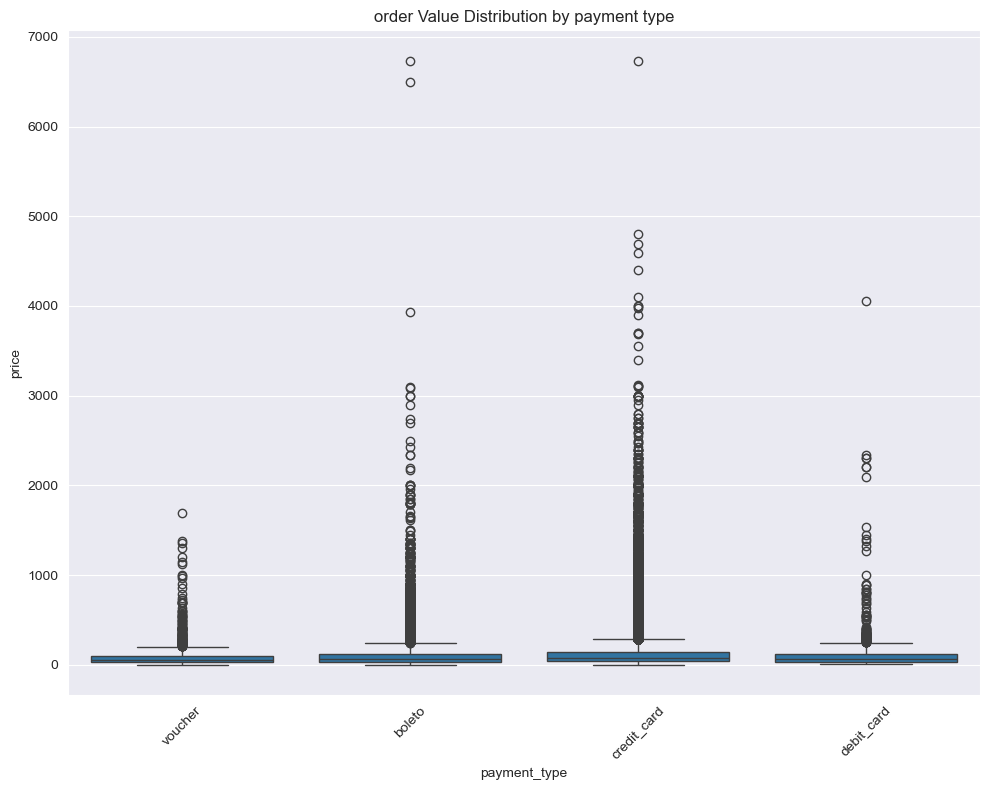

In [16]:
#boxplot of prices by payment type 
plt.figure(figsize=(10, 8))
sns.boxplot(data=main_df_with_payments, x='payment_type', y='price')
plt.title('order Value Distribution by payment type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()